# Six-bar mechanism balancing

###### Luis Eduardo Robles Jiménez

With this work, I pretend to find out the behavior of the function with different tools, in order to understand what the most important variables are, find patterns, identify overlapping zones of minima between the functions we're optimizing, graphing data, etc.

In [2]:
from BetaShF import *
from BetaShM import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sympy import *
import numpy as np
import scipy as sp
import time


assert ShF([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) == 1.0
assert ShM([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) == 1.0

#### Constraints

$$ -0.16m \leq x_{cn}, y_{cn} \leq 0.16m $$

$$ 0.005m \leq t_{cn} \leq 0.04m $$

#### Objective function

In [ ]:
def objective(s, ShF, ShM):
    return 0.5*ShF(s) + 0.5*ShM(s)

## Mathematical analysis 

### Sympy

In [3]:
from momentFormula import *
from forceFormula import *

In [ ]:
a = srepr(forceF)
b = srepr(momentF)

## Sample generation

In [ ]:
nSamples, nVariables = 500, 15
nWeights = nVariables // 3
samples = np.zeros((nSamples, nVariables))
bounds = np.zeros((nVariables, 2))
fitness = np.zeros((nSamples))
shForces = np.zeros((nSamples))
shMoments = np.zeros((nSamples))

### Differential Evolution

In [ ]:
for i in range(nVariables):
    if (i + 1) % 3 == 0: samples[:, i] = np.random.uniform(0.005, 0.04, (nSamples))
    else: samples[:, i] = np.random.uniform(-0.16, 0.16, (nSamples))
for i in range(nSamples):
    fitness[i] = objective(samples[i], ShF, ShM)
"""
for v in range(nVariables):
    bounds[v] = [0.005, 0.04] if (v + 1) % 3 == 0 else [-0.16, 0.16]
worst = 0.0
for s in range(nSamples):
    print("\rIteration:", s, "\tWorst fitness:", worst, end = "")
    p = False
    if s < nSamples // 10: p = True
    r = sp.optimize.differential_evolution(objective, bounds, args = (ShF, ShM), maxiter = 25, popsize = 10, polish = p)
    samples[s] = r.x
    fitness[s] = r.fun
    worst = np.max([worst, fitness[s]])
"""

### Pymoo

In [3]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

In [4]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=15,
                         n_obj=2,
                         n_ieq_constr=0,
                         xl=np.array([-0.16, -0.16, 0.005, -0.16, -0.16, 0.005, -0.16, -0.16, 0.005, -0.16, -0.16, 0.005, -0.16, -0.16, 0.005]),
                         xu=np.array([0.16, 0.16, 0.04, 0.16, 0.16, 0.04, 0.16, 0.16, 0.04, 0.16, 0.16, 0.04, 0.16, 0.16, 0.04]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = ShF(x)
        f2 = ShM(x)

        out["F"] = [f1, f2]
        out["G"] = []


problem = MyProblem()

In [5]:
algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

In [6]:
termination = get_termination("n_gen", 40)

In [7]:
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |      2 |             - |             -
     2 |       50 |      2 |  2.3413510304 |         ideal
     3 |       60 |      2 |  0.5409485544 |         ideal
     4 |       70 |      2 |  0.0615535000 |         ideal
     5 |       80 |      3 |  0.4806471457 |         ideal
     6 |       90 |      4 |  0.2851954969 |         ideal
     7 |      100 |      6 |  0.0198925037 |             f
     8 |      110 |      7 |  0.2465278567 |         ideal
     9 |      120 |      2 |  0.2211577408 |         ideal
    10 |      130 |      2 |  0.000000E+00 |             f
    11 |      140 |      2 |  0.6873742018 |         ideal
    12 |      150 |      3 |  0.1377911377 |             f
    13 |      160 |      3 |  0.2749032260 |             f
    14 |      170 |      3 |  0.000000E+00 |             f
    15 |      180 |      3 |  0.5433149725 |         ideal
    16 |      190 |      3 |  0.000000E+00 |            

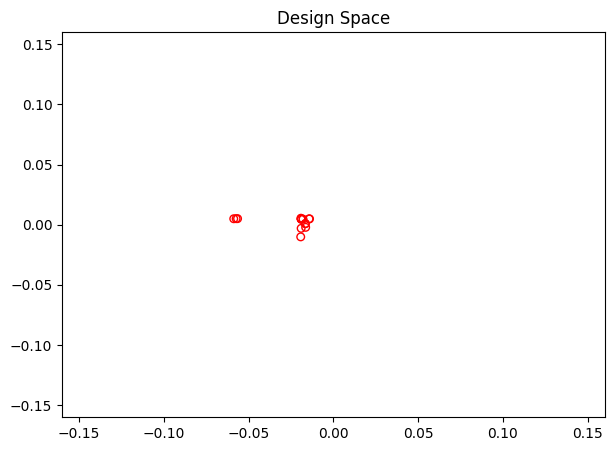

In [8]:
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

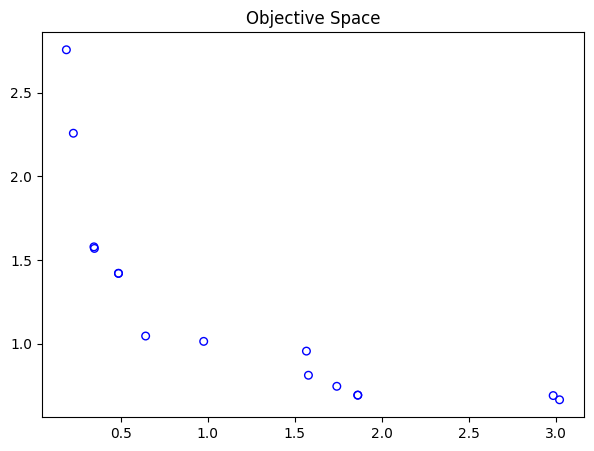

In [9]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

### Write data to a file

In [ ]:
now = str(int(time.time()))
np.savetxt(now + "Population.txt", samples)
np.savetxt(now + "Fitness.txt", fitness)
np.savetxt(now + "ShForces.txt", shForces)
np.savetxt(now + "ShMoments.txt", shMoments)